In [1]:
import numpy as np
import os
from patchify import patchify  # Only to handle large images
from PIL import Image  # Use Pillow for image handling
from datasets import Dataset

In [2]:
# Define paths for images and masks
image_dir = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/train/images"
mask_dir = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/train/masks"

In [3]:
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [4]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [5]:
all_img_patches = []
all_mask_patches = []

# Process images
for img_file in image_files:
    # Load each image using Pillow
    try:
        # Convert grayscale image to RGB
        large_image = Image.open(os.path.join(image_dir, img_file)).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {img_file} - {e}")
        continue
    
    # Convert the Pillow image to a NumPy array for patching
    large_image_np = np.array(large_image)
    
    # Patchify the large image (with 3 channels for RGB)
    patches_img = patchify(large_image_np, (patch_size, patch_size, 3), step=step)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)
images = np.array(all_img_patches).squeeze(1)

# Process masks
for mask_file in mask_files:
    # Load each mask using Pillow
    try:
        large_mask = Image.open(os.path.join(mask_dir, mask_file)).convert('L')  # Load as grayscale
    except Exception as e:
        print(f"Error loading mask: {mask_file} - {e}")
        continue
    
    # Convert the Pillow mask to a NumPy array for patching
    large_mask_np = np.array(large_mask)

    # Patchify the large mask
    patches_mask = patchify(large_mask_np, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize mask values to [0, 1]
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [6]:
print(images.shape)
print(masks.shape)

(2268, 256, 256, 3)
(2268, 256, 256)


Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [8]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [9]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1103
})

Let us make sure out images and masks (labels) are loading appropriately

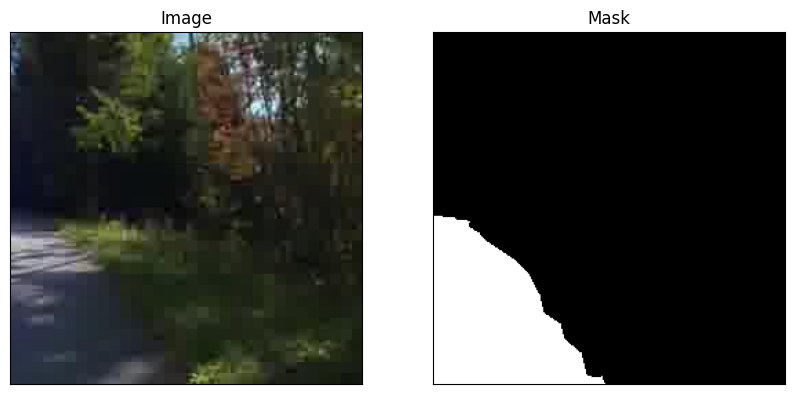

In [10]:
# Visualization
import matplotlib.pyplot as plt
import random

img_num = random.randint(0, filtered_images.shape[0] - 1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [11]:
# Get bounding boxes from mask
def get_bounding_box(ground_truth_map):
    # Get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox


In [12]:
# Dataset class for SAM model
from torch.utils.data import Dataset
from transformers import SamProcessor

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert('RGB')  # Ensure the image is RGB
        ground_truth_mask = np.array(item["label"])

        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [13]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [14]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [15]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [16]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [18]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [19]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [20]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [21]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:30<00:00,  1.23it/s]


EPOCH: 0
Mean loss: 0.081041746482631


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:15<00:00,  1.27it/s]


EPOCH: 1
Mean loss: 0.049711382266242006


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:21<00:00,  1.25it/s]


EPOCH: 2
Mean loss: 0.04423409798081317


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:17<00:00,  1.26it/s]


EPOCH: 3
Mean loss: 0.0408830309668016


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:20<00:00,  1.25it/s]


EPOCH: 4
Mean loss: 0.038550526020117104


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:14<00:00,  1.27it/s]


EPOCH: 5
Mean loss: 0.036944709205325096


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:17<00:00,  1.26it/s]


EPOCH: 6
Mean loss: 0.03544277940755305


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:29<00:00,  1.23it/s]


EPOCH: 7
Mean loss: 0.03622047855532256


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:19<00:00,  1.26it/s]


EPOCH: 8
Mean loss: 0.03591354578848172


100%|████████████████████████████████████████████████████████████████████████████████| 552/552 [07:25<00:00,  1.24it/s]

EPOCH: 9
Mean loss: 0.03215941343038087


In [22]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), r"E:/Random Python Scripts/Tata HaxS/Models/Models/SAM/Lmao/lmao2.pth")

**Inference**

In [23]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [24]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from patchify import patchify
from PIL import Image
from transformers import SamModel, SamConfig, SamProcessor

In [25]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
# Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load(r"E:/Random Python Scripts/Tata HaxS/Models/Models/SAM/Lmao/lmao2.pth"))

C:\Users\Siddharth\AppData\Local\Temp\ipykernel_20100\3331214106.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load(r"E:/Random Pyt

<All keys matched successfully>

In [26]:
# Set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

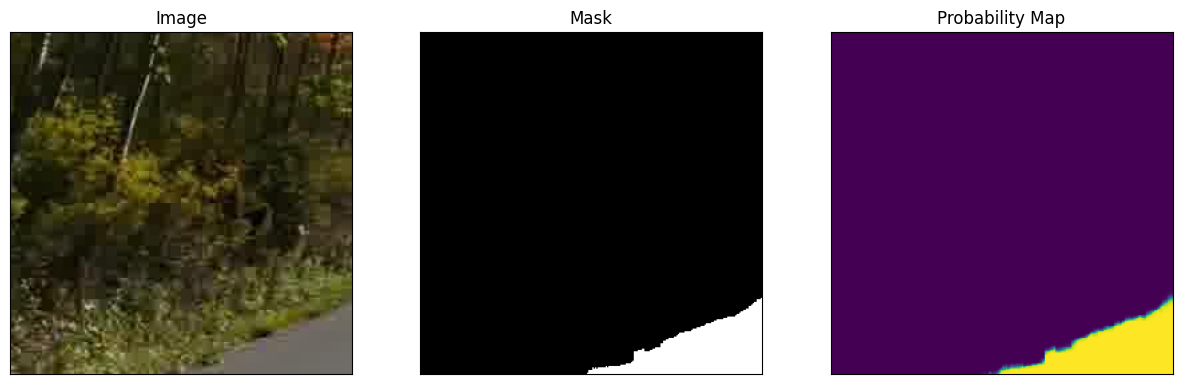

In [27]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [28]:
image_path = "E:/Random Python Scripts/Tata HaxS/SAM/Dataset/valid/images/092_jpg.rf.931c1135cb532a7665cfbc177ff948ff.jpg"
large_test_image = Image.open(image_path).convert('RGB')  # Ensure the image is RGB
large_test_image_np = np.array(large_test_image)

# Create patches from the large image
patches = patchify(large_test_image_np, (256, 256, 3), step=256)

In [29]:
# Define the size of your array (patch size)
array_size = 256
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size - 1, grid_size)
y = np.linspace(0, array_size - 1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of lists of lists (for input_points)
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

# Reshape grid to match input_points tensor shape: (batch_size, point_batch_size, num_points_per_image, 2)
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2)

print(np.array(input_points).shape)
print(patches.shape)

(1, 1, 100, 2)
(2, 3, 1, 256, 256, 3)


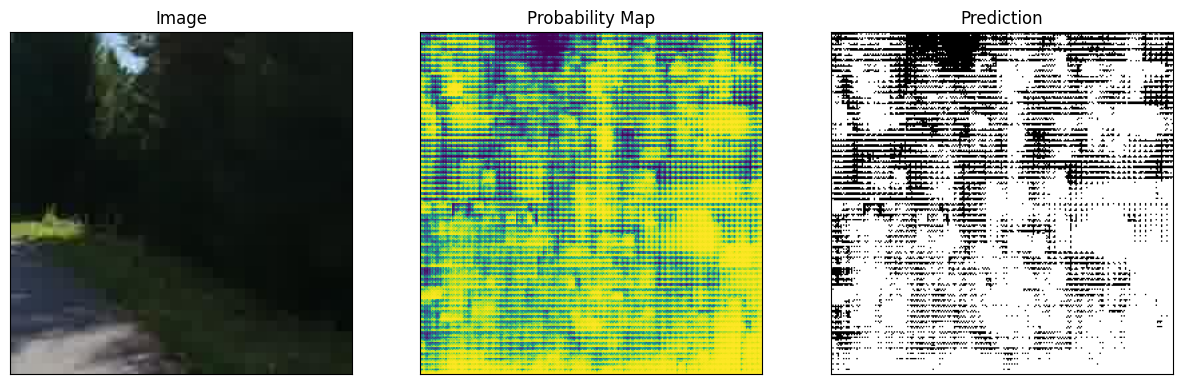

In [30]:
# Select a random patch for segmentation (remove the 1-dimensional singleton)
i, j = 1, 2  # Example indices for patch selection
random_patch = patches[i, j, 0]  # Remove the singleton dimension

# Convert patch to an image format
single_patch = Image.fromarray(random_patch)

# Now prepare image for the model with processor and input points
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set model to evaluation mode
my_mito_model.eval()

# Forward pass through the model
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Apply sigmoid to get probabilities
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()

# Convert soft mask to hard mask
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original patch image
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the patch is grayscale
axes[0].set_title("Image")

# Plot the probability map
axes[1].imshow(single_patch_prob)  # Plot probability map
axes[1].set_title("Probability Map")

# Plot the predicted mask
axes[2].imshow(single_patch_prediction, cmap='gray')  # Plot the hard mask
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the images side by side
plt.show()


## Inference

C:\Users\Siddharth\AppData\Local\Temp\ipykernel_20100\51282077.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"E:/Random Python Scrip

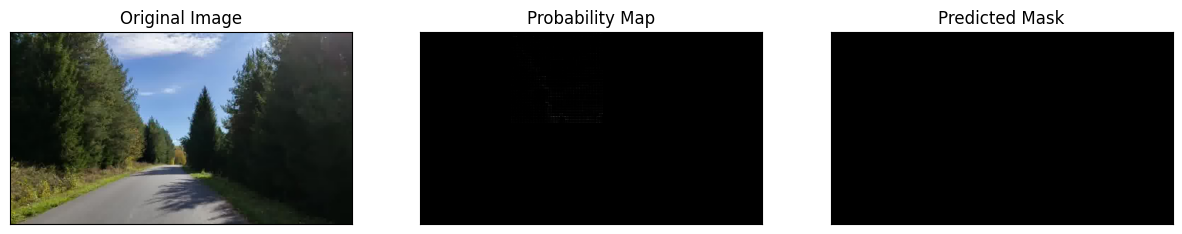

In [33]:
import numpy as np
import torch
from PIL import Image
from patchify import patchify, unpatchify  # This helps break and reassemble the image
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor, SamConfig

# Step 1: Load the image (works with .png, .jpg, and other formats)
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    return image

# Step 2: Break image into patches
def break_into_patches(image, patch_size=256):
    image_np = np.array(image)
    patches = patchify(image_np, (patch_size, patch_size, 3), step=patch_size)
    return patches

# Step 3: Stitch patches back together
def stitch_patches(patches, image_shape):
    stitched_image = unpatchify(patches, image_shape)
    return stitched_image

# Step 4: Visualize side-by-side original image and predictions
def show_predictions(image, prediction, probability_map):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")

    # Plot the probability map (soft mask)
    axes[1].imshow(probability_map, cmap='gray')
    axes[1].set_title("Probability Map")

    # Plot the prediction (hard mask)
    axes[2].imshow(prediction, cmap='gray')
    axes[2].set_title("Predicted Mask")

    # Remove axis labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Step 5: Main inference loop
def run_sam_on_image(image_path, model, processor, patch_size=256, device='cpu'):
    # Load image
    image = load_image(image_path)

    # Break image into patches
    patches = break_into_patches(image, patch_size=patch_size)
    patch_height, patch_width, _, patch_h, patch_w, _ = patches.shape

    # Prepare to collect outputs
    stitched_mask = np.zeros((image.height, image.width))
    stitched_prob_map = np.zeros((image.height, image.width))

    # Process each patch
    for i in range(patch_height):
        for j in range(patch_width):
            patch = patches[i, j, 0]  # Extract the patch (remove extra dimension)
            patch_image = Image.fromarray(patch)

            # Prepare patch for the model
            inputs = processor(patch_image, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Run model inference
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=False)

            # Apply sigmoid to get the probability map
            prob_map = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
            predicted_mask = (prob_map > 0.5).astype(np.uint8)

            # Reassemble the patches into full-size mask
            stitched_mask[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w] = predicted_mask
            stitched_prob_map[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w] = prob_map

    # Visualize side-by-side output
    show_predictions(image, stitched_mask, stitched_prob_map)

# Step 6: Load model and processor
def load_model():
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    model = SamModel(config=model_config)
    model.load_state_dict(torch.load(r"E:/Random Python Scripts/Tata HaxS/Models/Models/SAM/Lmao/lmao2.pth"))  # Load your trained model weights
    model.to(device)
    return model, processor

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model and processor
model, processor = load_model()

# Run the model on any image
image_path = r"E:/Random Python Scripts/Tata HaxS/SAM/Dataset/valid/images/092_jpg.rf.931c1135cb532a7665cfbc177ff948ff.jpg"  # Change to your image path
run_sam_on_image(image_path, model, processor, patch_size=256, device=device)
